<a href="https://colab.research.google.com/github/taliahtarik/dsprojectjterm/blob/main/pre_day_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
from google.colab import files
uploaded = files.upload()

Saving FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv to FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv


In [2]:
file = "FY_2024_Hospital_Readmissions_Reduction_Program_Hospital.csv"
data = pd.read_csv(file)

reconsidering if finding the mean for err is the best


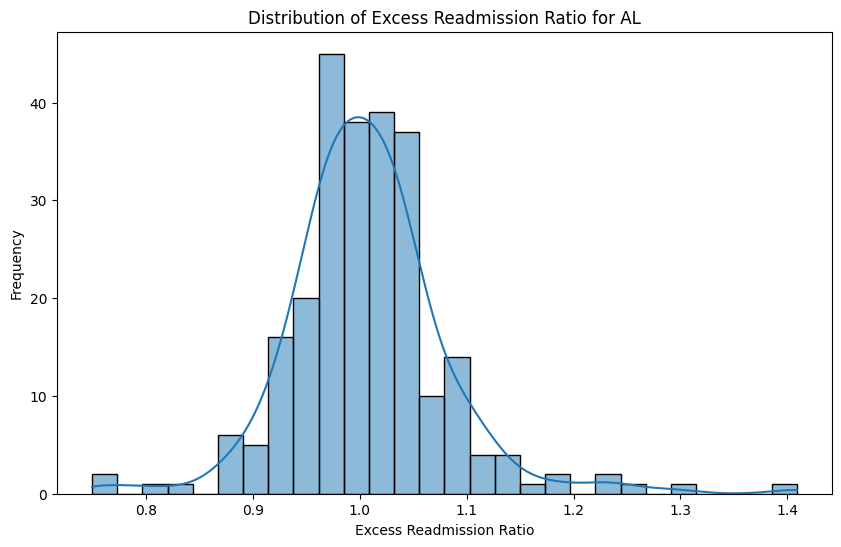

In [3]:
# prompt: write a code to see the distribution of Excess Readmission Ratio for one state

import matplotlib.pyplot as plt

# Assuming 'State' and 'Excess Readmission Ratio' columns exist
state_name = 'AL'  # Replace with the desired state
state_data = data[data['State'] == state_name]

plt.figure(figsize=(10, 6))
sns.histplot(state_data['Excess Readmission Ratio'], kde=True)
plt.title(f'Distribution of Excess Readmission Ratio for {state_name}')
plt.xlabel('Excess Readmission Ratio')
plt.ylabel('Frequency')
plt.show()

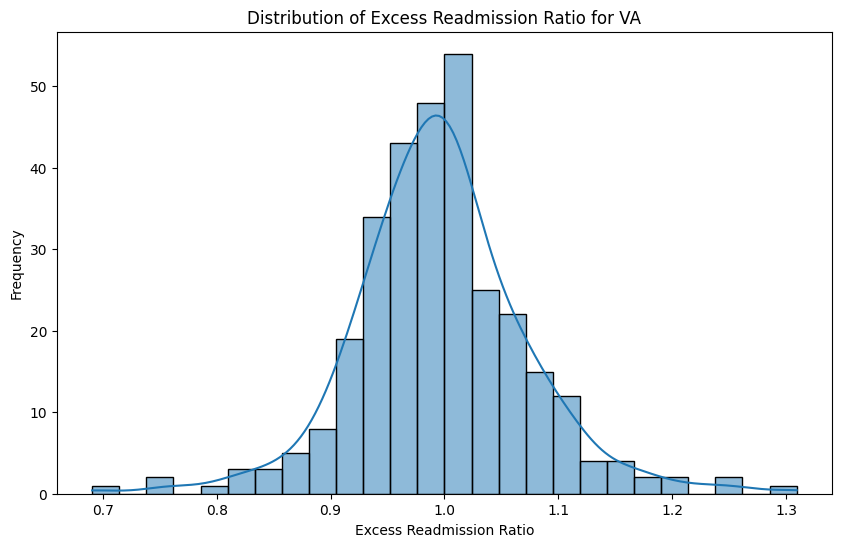

In [4]:
# Assuming 'State' and 'Excess Readmission Ratio' columns exist
state_name = 'VA'  # Replace with the desired state
state_data = data[data['State'] == state_name]

plt.figure(figsize=(10, 6))
sns.histplot(state_data['Excess Readmission Ratio'], kde=True)
plt.title(f'Distribution of Excess Readmission Ratio for {state_name}')
plt.xlabel('Excess Readmission Ratio')
plt.ylabel('Frequency')
plt.show()

seems like there aren't bad outliers atleast for AL and VA

In [5]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
q1 = data['Excess Readmission Ratio'].quantile(0.25)
q3 = data['Excess Readmission Ratio'].quantile(0.75)

# Calculate IQR
iqr = q3 - q1

# Define lower and upper bounds for outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers
outliers = data[(data['Excess Readmission Ratio'] < lower_bound) | (data['Excess Readmission Ratio'] > upper_bound)]

# Print the number of outliers and their bounds
print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
print(f"Number of outliers: {len(outliers)}")

# Display the outliers
outliers.head()


Lower bound: 0.8321499999999998, Upper bound: 1.1677500000000003
Number of outliers: 499


,Facility Name,Facility ID,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date
10,MARSHALL MEDICAL CENTERS,10005,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,0.7977,3.7634,4.7181,Too Few to Report,07/01/2019,06/30/2022
12,NORTH ALABAMA MEDICAL CENTER,10006,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,1.2468,5.5173,4.4251,Too Few to Report,07/01/2019,06/30/2022
94,UNIVERSITY OF ALABAMA HOSPITAL,10033,AL,READM-30-HIP-KNEE-HRRP,NaN,NaN,1.1785,8.0933,6.8672,Too Few to Report,07/01/2019,06/30/2022
114,HUNTSVILLE HOSPITAL,10039,AL,READM-30-CABG-HRRP,243.0,NaN,0.8286,8.2787,9.9909,15,07/01/2019,06/30/2022
115,HUNTSVILLE HOSPITAL,10039,AL,READM-30-HIP-KNEE-HRRP,334.0,NaN,1.2916,5.6980,4.4117,23,07/01/2019,06/30/2022


thinking bootstrapping might be the best - it estimates properties of a dataset (M, M, and SD), for me it provides a more robust estimate of ERR for each state, without being overly influenced by outliers or extreme values. it will include confidence intervals allowing for a more nuanced understanding of the variability within the states. this also improves fairness in representation of states.


In [9]:
# Check for missing values in the Excess Readmission Ratio column
print(data['Excess Readmission Ratio'].isnull().sum())

# Check for the number of entries per state
print(data['State'].value_counts())


6697
State
TX    1704
CA    1680
FL    1002
PA     822
NY     810
OH     714
IL     708
GA     582
MI     552
LA     510
NC     498
IN     492
AL     486
TN     480
OK     468
VA     426
WI     402
MO     396
NJ     384
AZ     384
KY     372
MS     372
MA     330
SC     306
CO     300
KS     288
WA     282
MN     276
AR     276
MD     264
OR     198
UT     198
IA     186
NM     180
CT     174
WV     150
NE     144
NV     138
SD     102
ME     102
ID      96
NH      78
MT      72
HI      72
WY      60
RI      60
AK      48
ND      42
VT      36
DE      36
DC      36
Name: count, dtype: int64


In [11]:
# important to add to data cleaning section
data = data.dropna(subset=['Excess Readmission Ratio'])

import numpy as np
import pandas as pd


# Bootstrapping function
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    states = data['State'].unique()
    bootstrap_results = []

    for state in states:
        state_data = data[data['State'] == state]['Excess Readmission Ratio']
        bootstrap_means = []

        # Perform bootstrapping
        for _ in range(n_bootstrap):
            sample = np.random.choice(state_data, size=len(state_data), replace=True)
            bootstrap_means.append(np.mean(sample))

        # Calculate confidence intervals
        lower_ci = np.percentile(bootstrap_means, (100 - ci) / 2)
        upper_ci = np.percentile(bootstrap_means, 100 - (100 - ci) / 2)
        bootstrap_results.append({
            'State': state,
            'Bootstrap Mean ERR': np.mean(bootstrap_means),
            'Lower CI': lower_ci,
            'Upper CI': upper_ci
        })

    return pd.DataFrame(bootstrap_results)

# Apply bootstrapping
bootstrap_results_df = bootstrap_ci(data)

# Preview the results
print(bootstrap_results_df.head())

# Save results for further analysis
bootstrap_results_df.to_csv("Bootstrap_Results.csv", index=False)


  State  Bootstrap Mean ERR  Lower CI  Upper CI
0    AL            1.006473  0.997683  1.015483
1    AK            0.986862  0.960790  1.015832
2    AZ            0.995558  0.984880  1.005899
3    AR            1.008044  0.997346  1.019303
4    CA            1.010640  1.005861  1.015303


Meaning: Alabama's boostrap mean ERR is 1.006473 (very slightly higher-than-expected readmissions). Lower CI or condfidence level means the lower limit within which the true mean ERR is likely to fall, because its .997683, it's possible but less likely that some facilities in Alabama perform on par with the expected readmissions. The upper CI / the upper limit of ERR is above 1, confirming that most facilites in Alabama have a slightly higher-than-expected readmissions.

overall, confidence intervals provide a range of uncertainty - narrower intervals suggest more consistency in hospital performance across the state - wider intervals indicate greater variability

(this is without the different conditions!)

In [15]:

data.columns

Index(['Facility Name', 'Facility ID', 'State', 'Measure Name',
       'Number of Discharges', 'Footnote', 'Excess Readmission Ratio',
       'Predicted Readmission Rate', 'Expected Readmission Rate',
       'Number of Readmissions', 'Start Date', 'End Date'],
      dtype='object')

bootstrapped means with the different conditions


In [14]:
# Bootstrapping function with 'Measure Name'
def bootstrap_ci(data, n_bootstrap=1000, ci=95):
    unique_groups = data.groupby(['State', 'Measure Name'])
    bootstrap_results = []

    for (state, measure_name), group_data in unique_groups:
        state_data = group_data['Excess Readmission Ratio']
        bootstrap_means = []

        # Perform bootstrapping
        for _ in range(n_bootstrap):
            sample = np.random.choice(state_data, size=len(state_data), replace=True)
            bootstrap_means.append(np.mean(sample))

        # Calculate confidence intervals
        lower_ci = np.percentile(bootstrap_means, (100 - ci) / 2)
        upper_ci = np.percentile(bootstrap_means, 100 - (100 - ci) / 2)
        bootstrap_results.append({
            'State': state,
            'Measure Name': measure_name,
            'Bootstrap Mean ERR': np.mean(bootstrap_means),
            'Lower CI': lower_ci,
            'Upper CI': upper_ci
        })

    return pd.DataFrame(bootstrap_results)

# Apply bootstrapping
bootstrap_results_df = bootstrap_ci(data)

# Preview the results
print(bootstrap_results_df.head())

# Save results for further analysis
bootstrap_results_df.to_csv("Bootstrap_Results.csv", index=False)


  State            Measure Name  Bootstrap Mean ERR  Lower CI  Upper CI
0    AK       READM-30-AMI-HRRP            0.967472  0.940860  0.997275
1    AK      READM-30-CABG-HRRP            0.886223  0.822700  0.950900
2    AK      READM-30-COPD-HRRP            0.995039  0.958659  1.041687
3    AK        READM-30-HF-HRRP            0.976009  0.940462  1.004088
4    AK  READM-30-HIP-KNEE-HRRP            1.041828  0.936510  1.166405


In [18]:
import plotly.graph_objects as go

# Map condition codes to descriptive names
condition_name_mapping = {
    'READM-30-AMI-HRRP': 'Heart Attack (AMI)',
    'READM-30-HF-HRRP': 'Heart Failure (HF)',
    'READM-30-PN-HRRP': 'Pneumonia',
    'READM-30-COPD-HRRP': 'Chronic Obstructive Pulmonary Disease (COPD)',
    'READM-30-HIP-KNEE-HRRP': 'Hip/Knee Replacement (THA/TKA)',
    'READM-30-CABG-HRRP': 'Coronary Artery Bypass Graft (CABG) Surgery'
}

# Replace measure names with descriptive names
bootstrap_results_df['Measure Name'] = bootstrap_results_df['Measure Name'].replace(condition_name_mapping)

# Dictionary to map state abbreviations to full names
state_abbrev_to_full = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts',
    'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana',
    'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico',
    'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Add full state names to the DataFrame
bootstrap_results_df['State Full Name'] = bootstrap_results_df['State'].map(state_abbrev_to_full)

# Define conditions
conditions = bootstrap_results_df['Measure Name'].unique()

# Create traces for each condition
choropleth_traces = []

for condition in conditions:
    condition_data = bootstrap_results_df[bootstrap_results_df['Measure Name'] == condition]

    trace = go.Choropleth(
        locations=condition_data['State'],
        locationmode='USA-states',
        z=condition_data['Bootstrap Mean ERR'],
        text=condition_data.apply(
            lambda row: f"State: {row['State Full Name']}<br>Mean ERR: {row['Bootstrap Mean ERR']:.3f}<br>CI: [{row['Lower CI']:.3f}, {row['Upper CI']:.3f}]",
            axis=1
        ),
        colorscale=[
            [0, 'darkgreen'],    # Below expected
            [0.5, 'yellow'],     # At expected
            [1, 'red']           # Above expected
        ],
        zmin=0.85,  # Adjust to keep balance
        zmax=1.15,  # Adjust to keep balance
        colorbar=dict(
            title="Mean ERR",
            titleside="right",
            tickvals=[0.9, 1, 1.1],
            ticktext=["Below Expected", "At Expected", "Above Expected"],
            ticks="outside"
        ),
        showscale=True,
        hoverinfo='text'
    )
    choropleth_traces.append(trace)

# Create layout with dropdown menu
layout = go.Layout(
    title="Bootstrap Mean ERR by State and Condition",
    geo=dict(
        scope='usa',
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="lightgray",
        projection_type="albers usa"
    ),
    updatemenus=[
        dict(
            active=0,
            buttons=[
                dict(
                    method='update',
                    label=condition,
                    args=[
                        {'visible': [i == idx for i in range(len(choropleth_traces))]},
                        {'title': f"Bootstrap Mean ERR for {condition}"}
                    ]
                ) for idx, condition in enumerate(conditions)
            ]
        )
    ]
)

# Create the figure
fig = go.Figure(data=choropleth_traces, layout=layout)

# Show the map
fig.show()


In [ ]:
# prompt: can you fix the top code to have the title be in the center

import pandas as pd
import seaborn as sns
from google.colab import files
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go

# ... (rest of your code)

# Create layout with dropdown menu and centered title
layout = go.Layout(
    title={
        'text': "Bootstrap Mean ERR by State and Condition",
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    geo=dict(
        scope='usa',
        showcoastlines=True,
        coastlinecolor="Black",
        showland=True,
        landcolor="lightgray",
        projection_type="albers usa"
    ),
    updatemenus=[
        dict(
            active=0,
            buttons=[
                dict(
                    method='update',
                    label=condition,
                    args=[
                        {'visible': [i == idx for i in range(len(choropleth_traces))]},
                        {'title': f"Bootstrap Mean ERR for {condition}"}
                    ]
                ) for idx, condition in enumerate(conditions)
            ]
        )
    ]
)